## Simulated Test Data

In [1]:
%%writefile Test/test.py

import numpy as np
import matplotlib.pyplot as plt

# Source matrix
a = ((np.arange(200)+1)-100)/100
a = np.concatenate((a,a,a,a,a), axis=0) 
b = np.sin((np.arange(1000)+1)/20)
S_test= np.vstack((b,a)).T
# Mixing matrix
A = np.array([0.291, 0.6557, -0.5439, 0.5572]).reshape((2, 2))
# test data
X_test = S_test @ A

def test(ic):
    np.random.seed(1)
    plt.subplot(121)
    plt.plot(np.arange(1000)+1, ic[:,0])
    plt.title("IC 1")
    plt.subplot(122)
    plt.plot(np.arange(1000)+1, ic[:,1])
    plt.title("IC 2")
pass

Overwriting Test/test.py


In [2]:
%run Test/test.py

### True Source Components

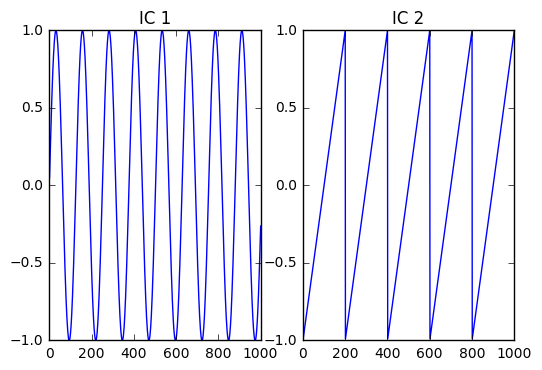

In [3]:
test(S_test)

### sklearn FastICA ICs

In [4]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=2)
S_sklearn= ica.fit_transform(X_test)

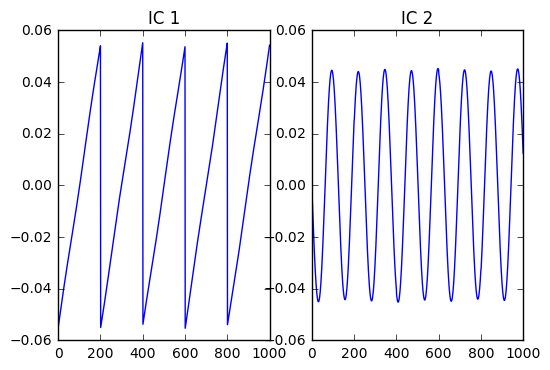

In [5]:
test(S_sklearn)

## Real World Data (fMRI)

This is a subsample of real fMRI data from the 1000 Connectome Project.

In [6]:
%%writefile Test/fMRI.py

import pandas as pd
df = pd.read_csv('PC.csv')
df.drop('Unnamed: 0',1,inplace=True)
fMRI = df.as_matrix()

Overwriting Test/fMRI.py


In [7]:
%run Test/fMRI.py

In [8]:
fMRI.shape

(30000, 20)

## Test Algorithm Accuracy

In [35]:
%run Source/fastICA_0.py
%run Source/fastICA_1.py
%run Source/fastICA_3.py
%run Source/fastICA_scipy.py
%run Source/fastICA_jit.py
%run Source/fastICA_ne.py

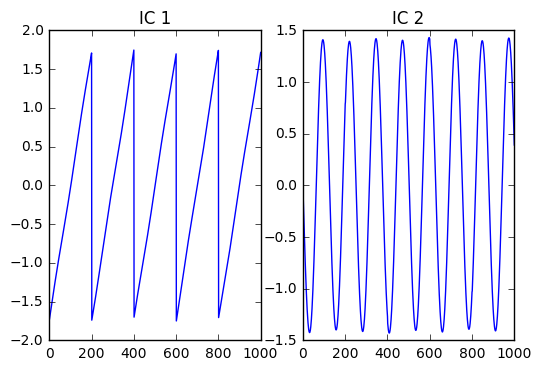

In [36]:
test(fastICA_0(X_test,f = "logcosh",n_comp =2, alpha = 1,maxit = 200, tol = 0.0001)['S'])

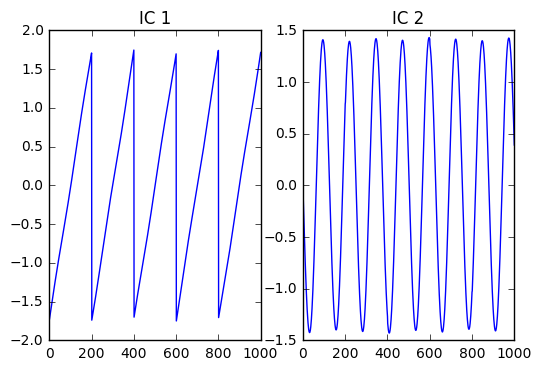

In [37]:
test(fastICA_1(X_test,f = "logcosh",n_comp =2, alpha = 1,maxit = 200, tol = 0.0001)['S'])

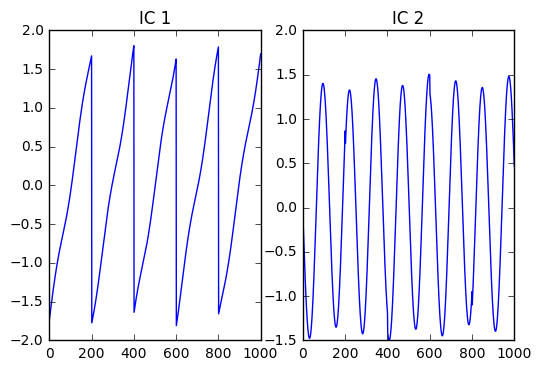

In [38]:
test(fastICA_3(X_test,f = "logcosh",n_comp =2, alpha = 1,maxit = 200, tol = 0.0001)['S'])

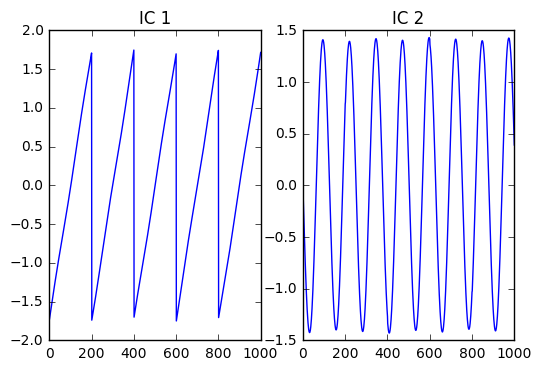

In [39]:
test(fastICA_scipy(X_test,f = "logcosh",n_comp =2, alpha = 1,maxit = 200, tol = 0.0001)['S'])

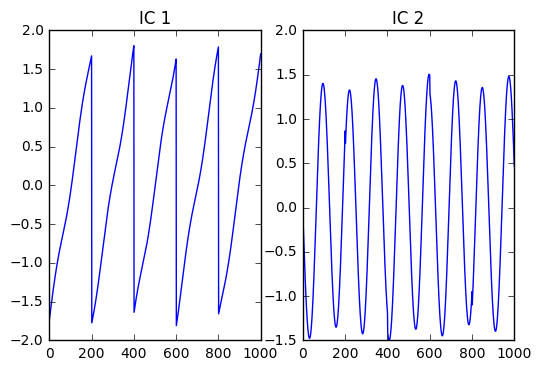

In [40]:
test(fastICA_jit(X_test,f = "logcosh",n_comp =2, alpha = 1,maxit = 200, tol = 0.0001)['S'])

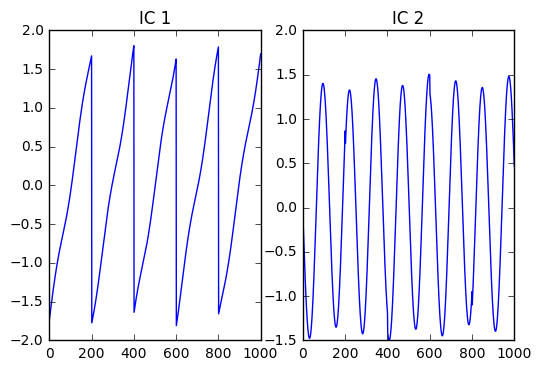

In [41]:
test(fastICA_ne(X_test,f = "logcosh",n_comp =2, alpha = 1,maxit = 200, tol = 0.0001)['S'])

## line_profiler

In [1]:
%%writefile Test/fastICA_00.py

import pandas as pd
import numpy as np
from sklearn import preprocessing

df = pd.read_csv('PC.csv')
df.drop('Unnamed: 0',1,inplace=True)
X = df.as_matrix()

def sym_decorrelation(W):
    """ Symmetric decorrelation """
    K = np.dot(W, W.T)
    s, u = np.linalg.eigh(K) 
    W = (u @ np.diag(1.0/np.sqrt(s)) @ u.T) @ W
    return W

def g_logcosh(wx,alpha):
    """derivatives of logcosh"""
    return np.tanh(alpha * wx)
def gprime_logcosh(wx,alpha):
    """second derivatives of logcosh"""
    return alpha * (1-np.square(np.tanh(alpha*wx)))
# exp
def g_exp(wx,alpha):
    """derivatives of exp"""
    return wx * np.exp(-np.square(wx)/2)
def gprime_exp(wx,alpha):
    """second derivatives of exp"""
    return (1-np.square(wx)) * np.exp(-np.square(wx)/2)

@profile
def fastICA_00(X, f,alpha=None, n_comp=None,maxit=200, tol=1e-04):
    """FastICA algorithm for several units"""
    n,p = X.shape
    #check if n_comp is valid
    if n_comp is None:
        n_comp = min(n,p)
    elif n_comp > min(n,p):
        print("n_comp is too large")
        n_comp = min(n,p)
        
    #centering
    #by subtracting the mean of each column of X (array).
    X = preprocessing.scale(X,axis = 0,with_std=False)
    X = X.T

    #whitening
    svd = np.linalg.svd(X @ (X.T) / n)
    k = np.diag(1/np.sqrt(svd[1])) @ (svd[0].T)
    k = k[:n_comp,:] 
    X1 = k @ X

    # initial random weght vector
    w_init = np.random.normal(size=(n_comp, n_comp))
    W = sym_decorrelation(w_init)
    lim = 1
    it = 0
    
    
    # The FastICA algorithm
    if f == "logcosh":
        while lim > tol and it < maxit :
            wx = W @ X1
            gwx = g_logcosh(wx,alpha)
            g_wx = gprime_logcosh(wx,alpha)
            W1 = np.dot(gwx,X1.T)/X1.shape[1] - np.dot(np.diag(g_wx.mean(axis=1)),W)
            W1 = sym_decorrelation(W1)
            it = it +1
            lim = np.max(np.abs(np.abs(np.diag(W1 @ W.T)) - 1.0))
            W = W1

        S = W @ X1
        A = np.linalg.inv(W @ k)
        X_re = A @ S
        return{'X':X1.T,'X_re':X_re.T,'A':A.T,'S':S.T}

    elif f == "exp":
        while lim > tol and it < maxit :
            wx = W @ X1
            gwx = g_exp(wx,alpha)
            g_wx = gprime_exp(wx,alpha)
            W1 = np.dot(gwx,X1.T)/X1.shape[1] - np.dot(np.diag(g_wx.mean(axis=1)),W)
            W1 = sym_decorrelation(W1)
            it = it +1
            lim = np.max(np.abs(np.abs(np.diag(W1 @ W.T)) - 1.0))
            W = W1

        S = W @ X1
        A = np.linalg.inv(W @ k)
        X_re = A @ S
        return{'X':X1.T,'X_re':X_re.T,'A':A.T,'S':S.T}

    else:
        print("doesn't support this approximation negentropy function")
        
fastICA_00(X,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

Overwriting Test/fastICA_00.py


In [2]:
! pip install line_profiler

In [3]:
!kernprof -l Test/fastICA_00.py

Wrote profile results to fastICA_00.py.lprof


In [5]:
!python -m line_profiler fastICA_00.py.lprof

Timer unit: 1e-06 s

Total time: 4.34743 s
File: Test/fastICA_00.py
Function: fastICA_00 at line 31

Line #      Hits         Time  Per Hit   % Time  Line Contents
    31                                           @profile
    32                                           def fastICA_00(X, f,alpha=None, n_comp=None,maxit=200, tol=1e-04):
    33                                               """FastICA algorithm for several units"""
    34         1           10     10.0      0.0      n,p = X.shape
    35                                               #check if n_comp is valid
    36         1            2      2.0      0.0      if n_comp is None:
    37                                                   n_comp = min(n,p)
    38         1            3      3.0      0.0      elif n_comp > min(n,p):
    39                                                   print("n_comp is too large")
    40                                                   n_comp = min(n,p)
    41                              

### Bottlenecks

We used line profiler to identify the bottlenecks.
From the result, it can be observed that the biggest bottleneck in the fastica function are "np.tanh" (in "g_logcosh" and "gprime_logcosh") and 'np.linalg.svd' function, which take about 90% percent of the time when running fastica function. The next bottleneck are 'preprocessing.scale'and matrix dot product.

## Parallelism

In [1]:
import numpy as np
import numexpr as ne

In [2]:
# "big" array
TT = np.random.normal(size=(10**5,10**3))

In [3]:
%%time
res = np.tanh(TT)

CPU times: user 3.4 s, sys: 468 ms, total: 3.87 s
Wall time: 3.9 s


In [4]:
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

In [5]:
%%time
with ThreadPoolExecutor(max_workers=4) as pool:
    res = pool.map(np.tanh, [i for i in TT])

CPU times: user 10.7 s, sys: 2.74 s, total: 13.4 s
Wall time: 9.77 s


In [6]:
%%time
with mp.Pool(processes=4) as pool:
    res = pool.map(np.tanh, [i for i in TT])

CPU times: user 1.77 s, sys: 2.46 s, total: 4.23 s
Wall time: 5.8 s


* Numexpr

In [10]:
ne.use_vml=False

In [12]:
%%time
res = ne.evaluate('tanh(TT)')

CPU times: user 456 ms, sys: 2.64 s, total: 3.09 s
Wall time: 543 ms


In [13]:
ne.use_vml=True

In [14]:
%%time
res = ne.evaluate('tanh(TT)')

CPU times: user 500 ms, sys: 424 ms, total: 924 ms
Wall time: 192 ms


VML can accelerate computations by a 50% using a single CPU.

In [19]:
ne.set_num_threads(1)

1

In [20]:
%%time
res = ne.evaluate('tanh(TT)')

CPU times: user 472 ms, sys: 1.28 s, total: 1.75 s
Wall time: 1.76 s


In [21]:
ne.detect_number_of_cores()

8

In [22]:
ne.set_num_threads(ne.detect_number_of_cores())

1

In [23]:
%%time
res = ne.evaluate('tanh(TT)')

CPU times: user 560 ms, sys: 608 ms, total: 1.17 s
Wall time: 285 ms


More threads make computations faster

## Time Comparison

In [42]:
%timeit -r2 -n4 fastICA_0(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 3.07 s per loop


In [44]:
%timeit -r2 -n4 fastICA_1(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 3.51 s per loop


In [49]:
%timeit -r2 -n4 fastICA_3(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 119 ms per loop


In [46]:
%timeit -r2 -n4 fastICA_scipy(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 3.26 s per loop


In [47]:
%timeit -r2 -n4 fastICA_jit(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 119 ms per loop


In [50]:
%timeit -r2 -n4 fastICA_ne(fMRI,f = "logcosh",n_comp =20, alpha = 1,maxit = 200, tol = 0.0001)

4 loops, best of 2: 78.3 ms per loop
